#  Project group 30 
## Image colorization by combining semantic segmentation and autoencoding 

Install dependencies

In [1]:
import torch
import torch.utils.data as data
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms
from torchvision.transforms import ToTensor
from torch import nn, optim
from torchvision.transforms import Compose, RandomGrayscale, ColorJitter, RandomHorizontalFlip, Resize, Normalize

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

from PIL import Image, ImageOps 

!pip install kornia
from matplotlib.colors import LinearSegmentedColormap
import kornia

import glob
import os

Path 

In [2]:
train_path = "\Train"

val_path = "\Validation"

test_path = "\Test"

Dataloader construction for segmentation

In [3]:
class DataLoaderSegmentation(data.Dataset):
    def __init__(self, folder_path, transform):
        super(DataLoaderSegmentation, self).__init__()
        
        #print(os.getcwd() + "\Dataset" + folder_path + "\Images\*.png")
        self.transform = transform
        
        self.img_files = glob.glob(os.getcwd() + "\Dataset" + folder_path + "\Images\*.png")
        self.mask_files = glob.glob(os.getcwd() + "\Dataset" + folder_path + "\Labels\*.png")

    def __getitem__(self, index):
            img_path = self.img_files[index]
            mask_path = self.mask_files[index]
            
            data = Image.open(img_path) # PIL images
            data = ImageOps.grayscale(data) 
        
            label = Image.open(mask_path) 
            
            # Perform transforms, if any.
            if self.transform is not None:
                data = self.transform(data)
                label = self.transform(label)
            
            data = np.array(data)
            np.moveaxis(data, 0, -1).shape
            
            label = np.array(label)
            np.moveaxis(label, 0, -1).shape

            # GÖR OM TILL GREY SCALE
            
            return torch.from_numpy(data).float(), torch.from_numpy(label).float()

    def __len__(self):
        return len(self.img_files)

Create dataloaders for segmentation

In [4]:
#example_transform = Compose([Resize((128,128), antialias=True)])
#example_dataset = DataLoaderSegmentation(train_path,example_transform)
batch_size = 16
n_classes = 35 # Crashes if too low idk why 
img_size = 256

train_transforms = Compose([Resize((img_size,img_size), antialias=True)])

train_set = DataLoaderSegmentation(train_path, train_transforms)
val_set = DataLoaderSegmentation(val_path, train_transforms)


train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

Perform transforms on the images maybe??

Visualize test image for the dataloader of the segmentation part

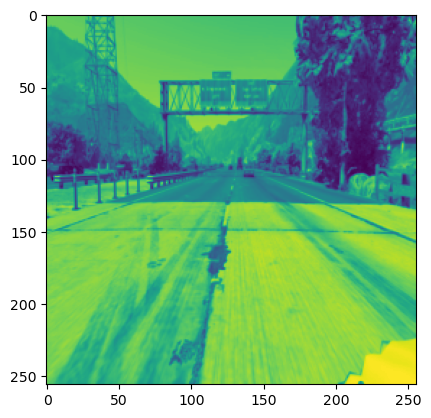

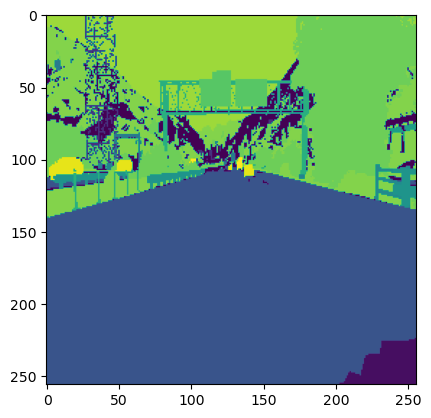

In [5]:
example_transform = Compose([Resize((img_size,img_size), antialias=True)])
example_dataset = DataLoaderSegmentation(train_path,example_transform)

img, label = example_dataset[30]

plt.figure(0)
plt.imshow(img/torch.max(img))
plt.figure(1)
plt.imshow(label)

Build the model class for segmentation

In [6]:
# Source
# https://medium.com/analytics-vidhya/unet-implementation-in-pytorch-idiot-developer-da40d955f201
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU()
            
    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x

    
class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))
    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)
        return x, p

class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)
    def forward(self, inputs, skip):
        x = self.up(inputs) 
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x

    
class build_unet(nn.Module):
    def __init__(self):
        super().__init__()
        """ Encoder """
        self.e1 = encoder_block(1, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)
        """ Bottleneck """
        self.b = conv_block(512, 1024)
        """ Decoder """
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64) 
        """ Classifier """
        self.outputs = nn.Conv2d(64, n_classes, kernel_size=1, padding=0) # 32 or 31 channels
    def forward(self, inputs):
        """ Encoder """
        inputs = inputs.permute(1,0,2,3)
        s1, p1 = self.e1(inputs)  
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)
        """ Bottleneck """
        b = self.b(p4)
        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)
        """ Classifier """
        outputs = self.outputs(d4)
        return outputs

Build the training loop for segmentation

In [7]:
# custom colormap
#cmap = colors.ListedColormap(['k','b','y','g','r','darkorange','forestgreen','lime','seagreen','royalblue','navy','indigo','teal','gold','tan','aqua','coral','olive','purple','maroon','turquoise','lightsalmon','pink','plum','khaki','lawngreen','peru','lightgray','wheat','sienna','fuchsia','thistle'])

def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

cmap = get_cmap(n_classes)

def training_loop(model, optimizer, loss_fn, train_loader, val_loader, num_epochs, print_every):
    print("Starting training")
    device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
    model.to(device)
    train_losses, val_losses = [], []

    for epoch in range(1, num_epochs+1):
        model, train_loss = train_epoch(model,
                                       optimizer,
                                       loss_fn,
                                       train_loader,
                                       val_loader,
                                       device,
                                       print_every)
        
        # Validate fucks up
        val_loss = validate(model, loss_fn, val_loader, device)
        print(f"Epoch {epoch}/{num_epochs}: "
              f"Train loss: {sum(train_loss)/len(train_loss):.3f}, "
              f"Val. loss: {val_loss:.3f}, ")
        train_losses.extend(train_loss)
        val_losses.append(val_loss)

        file_name = 'loss_seg.txt';
        with open(file_name, "a") as file:
            file.write(f"Train loss epoch: {sum(train_loss)/len(train_loss):.3f}, Val. loss epoch: {val_loss:.3f}\n")

        # Save model to disk after each epoch
        torch.save(model.state_dict(), 'segmentation_model.pth')
        
    return model, train_losses, val_losses

def train_epoch(model, optimizer, loss_fn, train_loader, val_loader, device, print_every):
    # Train:
    model.train()
    train_loss_batches = []
    num_batches = len(train_loader)
    for batch_index, (x, y) in enumerate(train_loader, 1):    
        inputs, labels = x.to(device), y.to(device)
        inputs = inputs[None, :]
        
        optimizer.zero_grad()
        z = model.forward(inputs)
        #z = z.permute(0, 2, 3, 1)  # Change the channel dimension to the last
        #z = z.permute(0, 3, 1, 2) #[Batch, class, img, img]

        #print("label size: ", labels.shape) #[batch, img, img]
        #labels = labels.view(-1)  # Reshape to (N*H*W,)
        
        
        #print("before loss_fn")
        #print("z.shape: ", z.shape)
        #print("labels.shape: ", labels.shape)
        loss = loss_fn(z, labels.long())
        #loss = loss_fn(z, labels.float())
        loss.backward()
        optimizer.step()
        train_loss_batches.append(loss.item())

        print(f"\tBatch {batch_index}/{num_batches}")
        # If you want to print your progress more often than every epoch you can
        # set `print_every` to the number of batches you want between every status update.
        # Note that the print out will trigger a full validation on the full val. set => slows down training
        if print_every is not None and batch_index % print_every == 0:
            val_loss = validate(model, loss_fn, val_loader, device)
            model.train()
            print(f"\tTrain loss: {sum(train_loss_batches[-print_every:])/print_every:.3f}, "
                  f"\tVal. loss: {val_loss:.3f}, ")

            file_name = 'loss_seg.txt';
            with open(file_name, "a") as file:
                file.write(f"Train loss batch: {sum(train_loss_batches[-print_every:])/print_every:.3f}, Val. loss batch: {val_loss:.3f}\n")

    return model, train_loss_batches

def validate(model, loss_fn, val_loader, device):
    val_loss_cum = 0
    model.eval()
    with torch.no_grad():
        for batch_index, (x, y) in enumerate(val_loader, 1):
            inputs, labels = x.to(device), y.to(device)
            inputs = inputs[None, :]
            
            z = model.forward(inputs)
            z = torch.round(z)
            batch_loss = loss_fn(z, labels.long()) 
            val_loss_cum += batch_loss.item()      
            
            # Visual test
            if batch_index == 1:
                z, _ = torch.max(z[0,:,:,:],dim=0)
                f, axarr = plt.subplots(1,3)
                axarr[0].imshow(inputs[0,0,:,:],'grey')
                
                # With static cmap
                #print(z[:,:])
                #print(labels[0,:,:].float())
                axarr[1].imshow(z[:,:],cmap)
                axarr[2].imshow(labels[0,:,:].float(),cmap)

                # Without static cmap
                #axarr[1].imshow(z[0,:,:])
                #axarr[2].imshow(labels.float()[0,:,:])
                
                plt.show()
                # Save the model each time we plot (REMOVE LATER)
                torch.save(model.state_dict(), 'segmentation_model.pth')

    return val_loss_cum/len(val_loader)

C:\Users\soder\AppData\Local\Temp\ipykernel_8092\2879221198.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  return plt.cm.get_cmap(name, n)


Training the segmentation part

Creating new model
Starting over writing to loss textfile
Starting training
	Batch 1/125
	Batch 2/125
	Batch 3/125
	Batch 4/125
	Batch 5/125
	Batch 6/125
	Batch 7/125
	Batch 8/125
	Batch 9/125
	Batch 10/125
	Batch 11/125
	Batch 12/125
	Batch 13/125
	Batch 14/125
	Batch 15/125
	Batch 16/125
	Batch 17/125
	Batch 18/125
	Batch 19/125
	Batch 20/125
	Batch 21/125
	Batch 22/125
	Batch 23/125
	Batch 24/125
	Batch 25/125


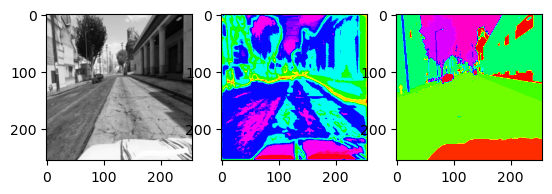

KeyboardInterrupt: 

In [8]:
train_from_disk = False

if train_from_disk:  
    # Read model from disk
    print("Reading model from disk")
    pretrained = torch.load('segmentation_model.pth', map_location=lambda storage, loc: storage)
    Segmentaion_model = build_unet()
    Segmentaion_model.load_state_dict(torch.load('segmentation_model.pth'))
    file_name = 'loss_seg.txt'
    print("Continue writing to loss textfile")
    with open(file_name, "a") as file:
        file.write('Continue:\n') 
else:
    # Create new model
    print("Creating new model")
    Segmentaion_model = build_unet()
    file_name = 'loss_seg.txt'
    print("Starting over writing to loss textfile")
    with open(file_name, "w") as file:
        file.write('Losses:\n')


optimizer = optim.Adam(Segmentaion_model.parameters(), lr =0.001)
#loss_fn = nn.MSELoss() # kass som faen
loss_fn = nn.CrossEntropyLoss() # mindre kass
train_loader = train_dataloader 
val_loader = val_dataloader
num_epochs = 20
print_every = 25

Segmentaion_model, Segmentaion_train_losses, Segmentaion_val_losses = training_loop(Segmentaion_model, optimizer, loss_fn, train_loader, val_loader, num_epochs, print_every)